# EDA: Capstone Two - Predicting house prices

## Introduction

The dataset used in this project was obtained from https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset The Kaggle command API is !kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

## Objective

Predict the price of a housing unit using the physical features of that unit.

## Libraries aand Packages

In [1]:
## Import libraries and packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Dataset

In [2]:
# Load data into a pandas DataFrame

data1 = pd.read_csv('housingdata.csv')

In [3]:
data1.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,140499.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN


In [4]:
print(data1.shape)

(526989, 12)


In [5]:
# Convert brokered_by, street, and zip_code columns into strings
data1['brokered_by'] = data1['brokered_by'].astype(str)
data1['street'] = data1['street'].astype(str)
data1['zip_code'] = data1['zip_code'].astype(str)

In [6]:
# Remove trailing zero
data1['brokered_by'] = data1['brokered_by'].str.rstrip('.0')
data1['street'] = data1['street'].str.rstrip('.0')
data1['zip_code'] = data1['zip_code'].str.rstrip('.0')

In [7]:
# Convert bed column to an integer
data1['bed'] = data1['bed'].astype(int)

In [8]:
data1.info()
data1.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526989 entries, 0 to 526988
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   brokered_by     526989 non-null  object 
 1   status          526989 non-null  object 
 2   price           526625 non-null  float64
 3   bed             526989 non-null  int32  
 4   bath            526989 non-null  float64
 5   acre_lot        526989 non-null  float64
 6   street          526989 non-null  object 
 7   city            526878 non-null  object 
 8   state           526989 non-null  object 
 9   zip_code        526989 non-null  object 
 10  house_size      526989 non-null  float64
 11  prev_sold_date  329991 non-null  object 
dtypes: float64(4), int32(1), object(7)
memory usage: 46.2+ MB


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378,for_sale,105000.0,3,2.0,0.12,1962661,Adjuntas,Puerto Rico,601,920.0,NaN
1,52707,for_sale,80000.0,4,2.0,0.08,1902874,Adjuntas,Puerto Rico,601,1527.0,NaN
2,103379,for_sale,67000.0,2,1.0,0.15,140499,Juana Diaz,Puerto Rico,795,748.0,NaN


## Missing values

<Axes: >

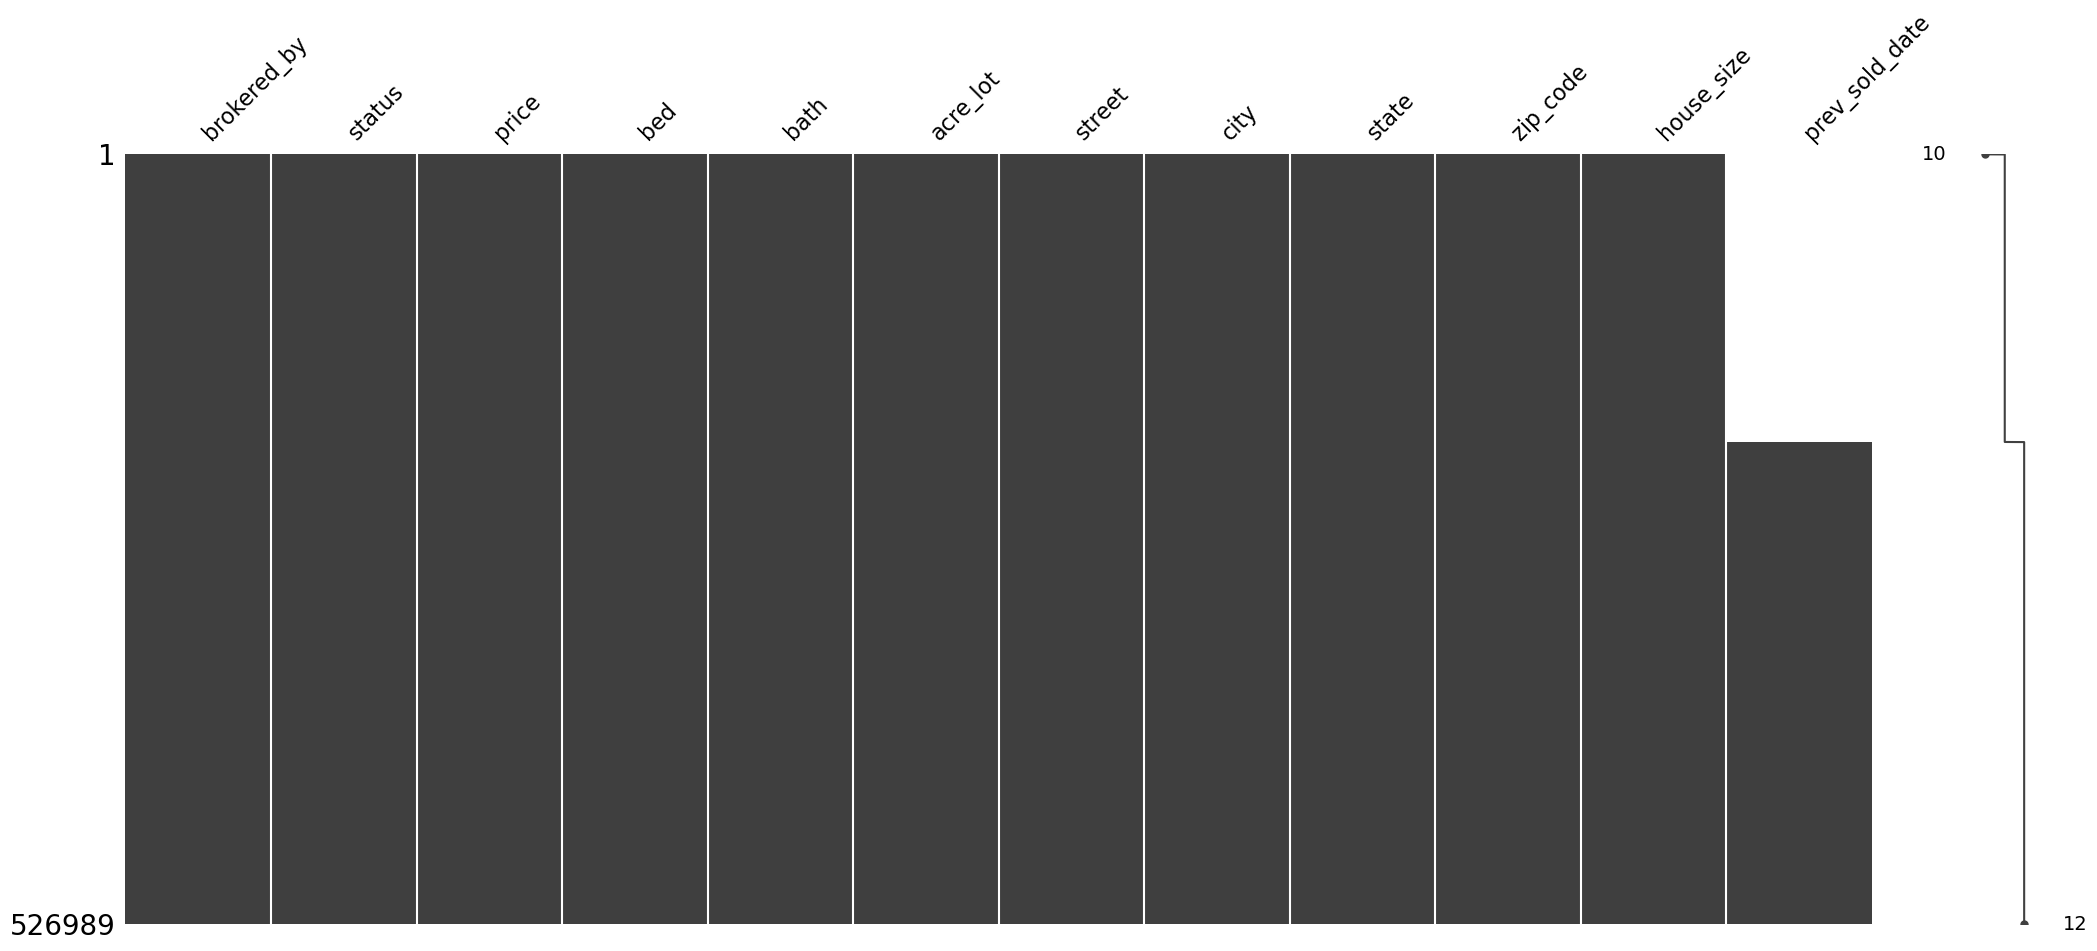

In [9]:
# Visualizing null values
msno.matrix(data1, sort='ascending')

In [10]:
# Check for missing values in each column
print("\nMissing values in each column:")
print(data1.isna().sum())


Missing values in each column:
brokered_by            0
status                 0
price                364
bed                    0
bath                   0
acre_lot               0
street                 0
city                 111
state                  0
zip_code               0
house_size             0
prev_sold_date    196998
dtype: int64


## Outliers

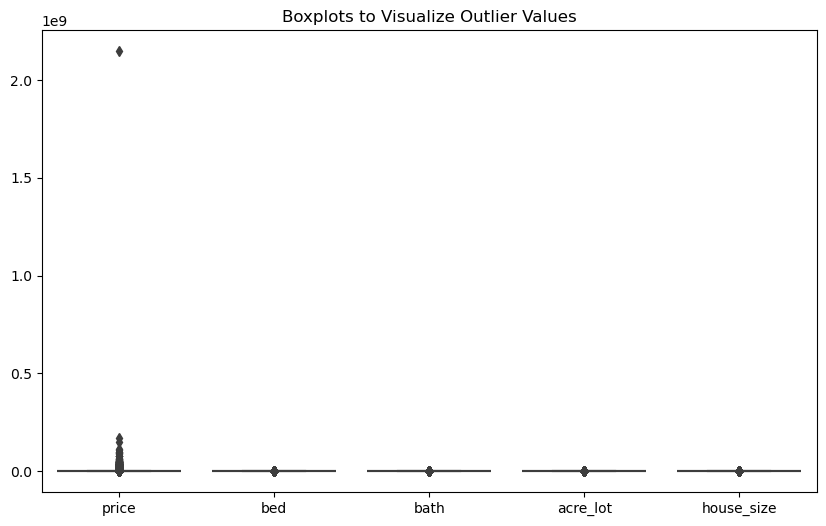

In [11]:
# Create box plots for each column
plt.figure(figsize=(10, 6))
sns.boxplot(data=data1)
plt.title('Boxplots to Visualize Outlier Values')
plt.show();

In [12]:
# Maximun value in price column
max_price = data1['price'].max()
print(f"Maximum value of a house in price is:", {max_price})

Maximum value of a house in price is: {2147483600.0}


The maximum price appears to be extremely high at $2147483600.00, probably an error in typing. Let's drop this price.

In [13]:
data1 = data1[data1['price'] != max_price]

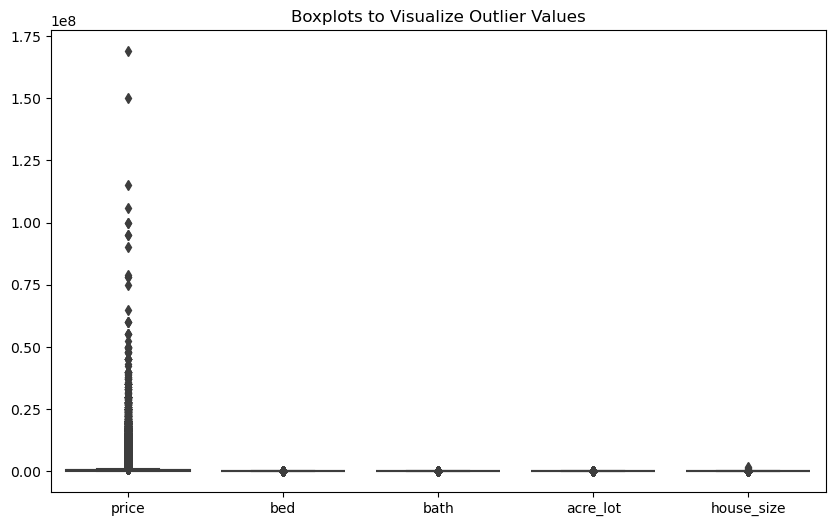

In [14]:
# Create box plots for each column
plt.figure(figsize=(10, 6))
sns.boxplot(data=data1)
plt.title('Boxplots to Visualize Outlier Values')
plt.show();

In [15]:
data1.describe()

,price,bed,bath,acre_lot,house_size
count,5.266240e+05,526988.000000,526988.000000,526988.000000,5.269880e+05
mean,5.179398e+05,3.449828,2.587998,13.626334,2.204872e+03
std,1.153888e+06,1.349672,1.396112,836.537917,3.578818e+03
min,0.000000e+00,1.000000,1.000000,0.000000,1.000000e+02
25%,2.000000e+05,3.000000,2.000000,0.150000,1.388000e+03
50%,3.312345e+05,3.000000,2.000000,0.250000,1.862000e+03
75%,5.250000e+05,4.000000,3.000000,0.610000,2.586000e+03
max,1.690000e+08,190.000000,198.000000,100000.000000,1.560780e+06


Looking at the minimum and maximum values in the description table, there seems to be more extreme values. 

In [16]:
data1_numeric = data1.select_dtypes(include=np.number)
# Calculate the IQR 
q1 = data1_numeric.quantile(0.25)
q3 = data1_numeric.quantile(0.75)
iqr = q3 - q1

#Define bounds
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Remove outliers
num_mask = ((data1_numeric >= lower) & (data1_numeric <= upper)).all(axis=1)
data2 = data1[num_mask]

In [17]:
print(data2.shape)

(395649, 12)


## Exploring potential relationships

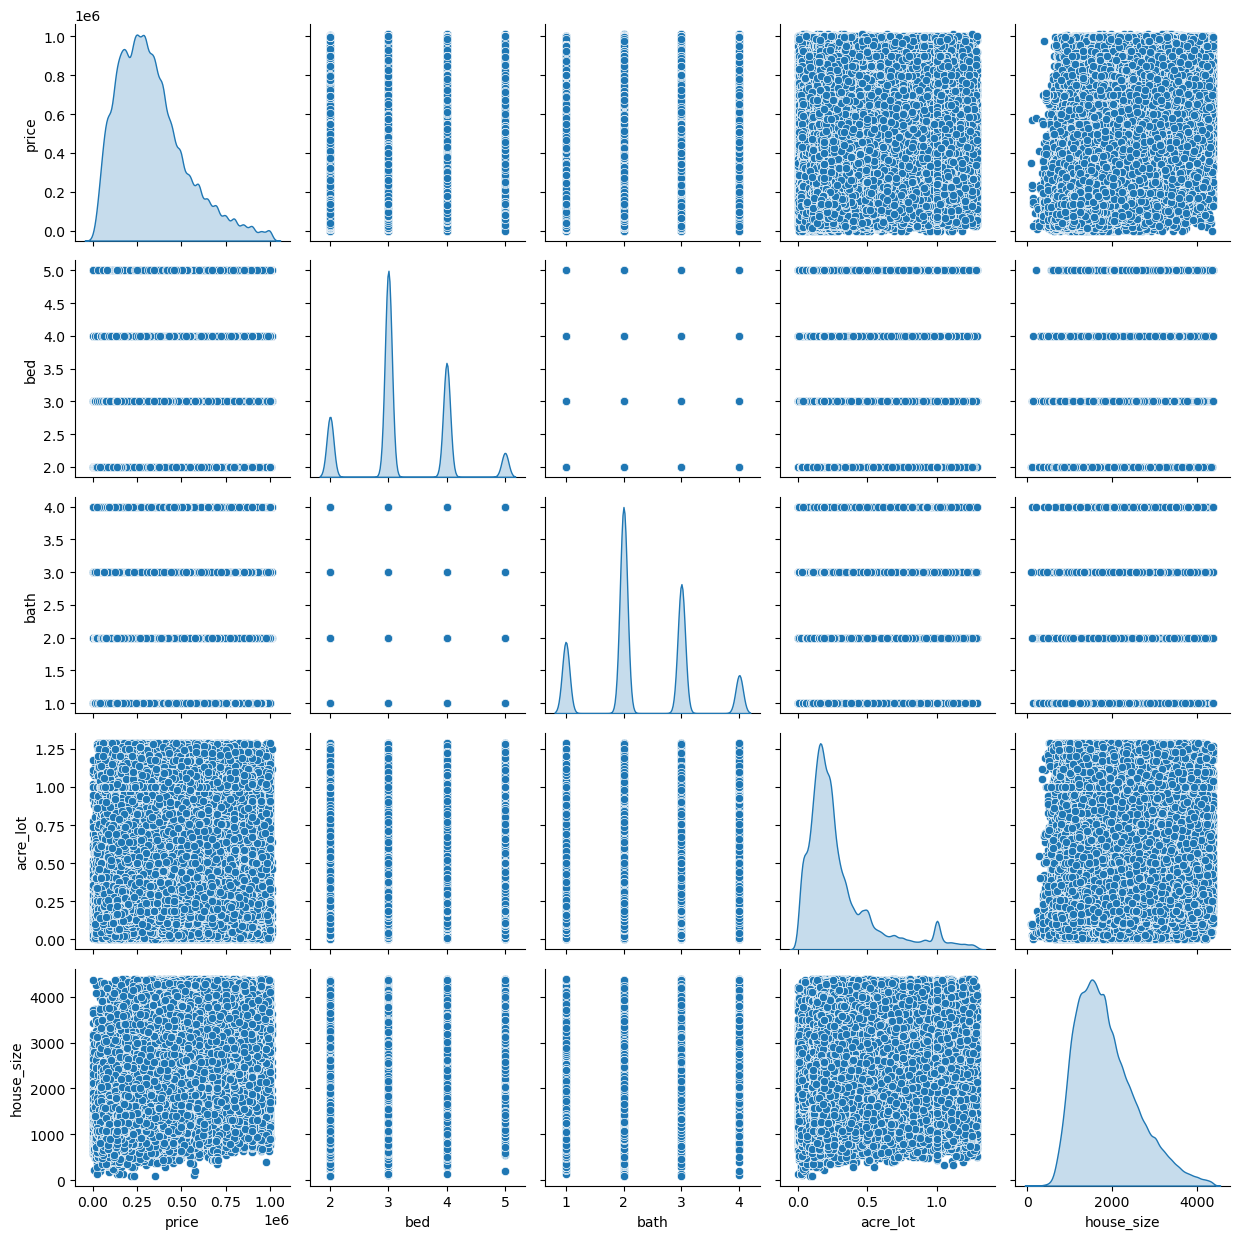

In [18]:
# Create pairplots for numeric columns
sns.pairplot(data2, diag_kind='kde')

# Plot layout
plt.tight_layout()

# Display
plt.show();

<Axes: >

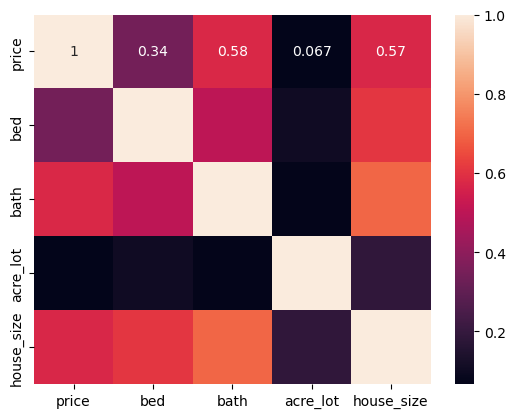

In [19]:
# Creat a correlation heatmap for numeric columns only
data2_numeric = data2.select_dtypes(include=np.number)

sns.heatmap(data2_numeric.corr(), annot=True)

In [20]:
data2.price.unique()

array([105000.,  80000.,  67000., ..., 523171., 467847., 456122.])

In [21]:
data2.bed.unique()

array([3, 4, 2, 5])

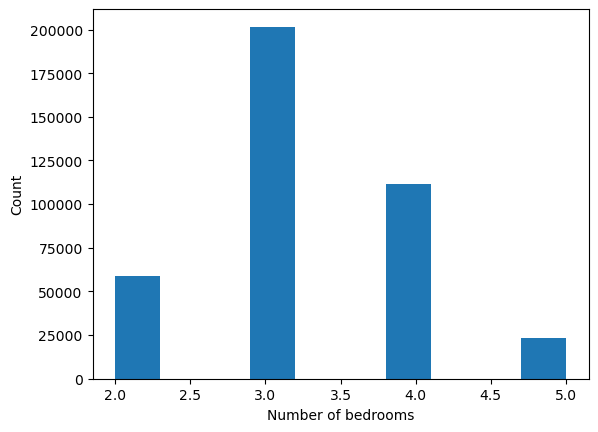

In [22]:
plt.hist(data2.bed)
plt.xlabel("Number of bedrooms")
plt.ylabel("Count")
plt.show();

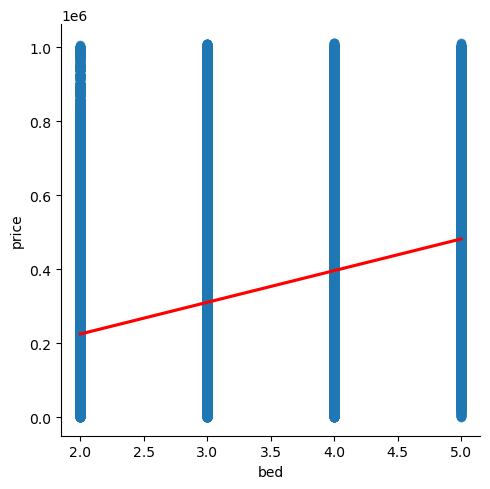

In [23]:
sns.lmplot(x='bed',y='price',data=data2, line_kws={'color': 'red'})
plt.show();

In [24]:
data2.bath.unique()

array([2., 1., 3., 4.])

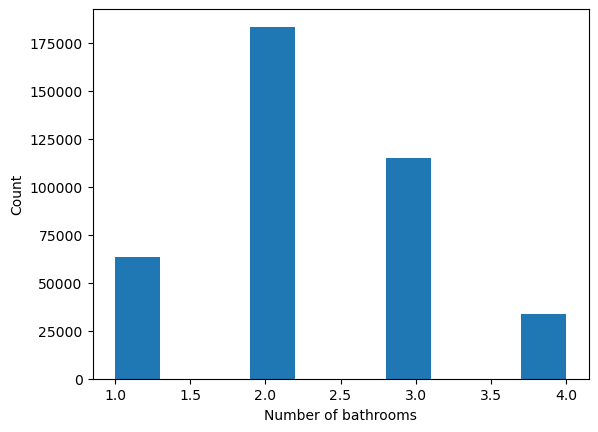

In [25]:
plt.hist(data2.bath)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")
plt.show();

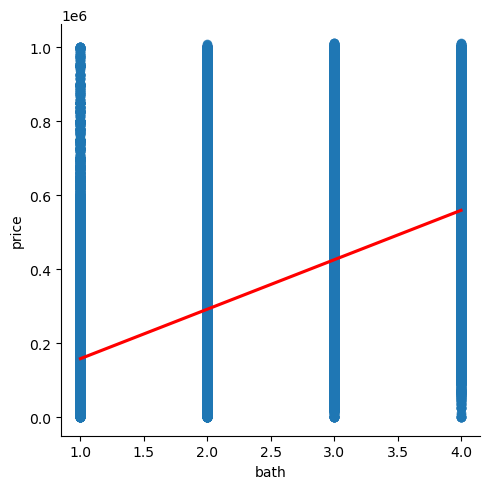

In [26]:
sns.lmplot(x='bath',y='price',data=data2, line_kws={'color': 'red'})
plt.show();

In [27]:
data2.rename(columns={'acre_lot':'lot_size'}, inplace=True)


C:\Users\MTIDES\AppData\Local\Temp\ipykernel_2796\1668714345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.rename(columns={'acre_lot':'lot_size'}, inplace=True)


In [28]:
data2.lot_size.unique()

array([0.12, 0.08, 0.15, 0.1 , 0.46, 0.2 , 0.09, 0.22, 0.23, 0.05, 0.28,
       0.3 , 0.11, 0.04, 0.69, 1.13, 0.24, 0.16, 0.13, 0.07, 0.89, 0.26,
       0.17, 0.33, 0.21, 0.95, 0.52, 0.35, 0.14, 0.19, 0.25, 0.49, 0.27,
       0.86, 0.29, 0.06, 0.61, 1.22, 0.48, 0.97, 0.03, 0.38, 1.21, 1.17,
       1.16, 0.51, 0.72, 0.8 , 0.68, 0.74, 0.18, 0.4 , 0.32, 0.43, 0.37,
       0.54, 0.83, 0.59, 0.31, 0.42, 0.36, 0.39, 0.02, 1.15, 0.57, 0.44,
       1.12, 0.88, 0.82, 0.58, 0.5 , 0.41, 0.78, 0.01, 1.03, 1.09, 0.  ,
       1.  , 0.34, 0.67, 0.93, 0.55, 1.18, 0.94, 1.19, 1.02, 0.92, 0.56,
       0.77, 0.91, 0.76, 0.53, 1.23, 0.7 , 1.01, 0.47, 0.65, 0.45, 0.64,
       0.73, 0.63, 0.6 , 1.08, 1.27, 0.85, 0.66, 0.62, 1.07, 0.84, 1.2 ,
       1.06, 0.87, 0.96, 0.81, 0.9 , 1.26, 0.71, 0.75, 1.14, 0.79, 1.11,
       1.1 , 1.25, 1.05, 1.04, 0.98, 1.28, 1.29, 0.99, 1.24])

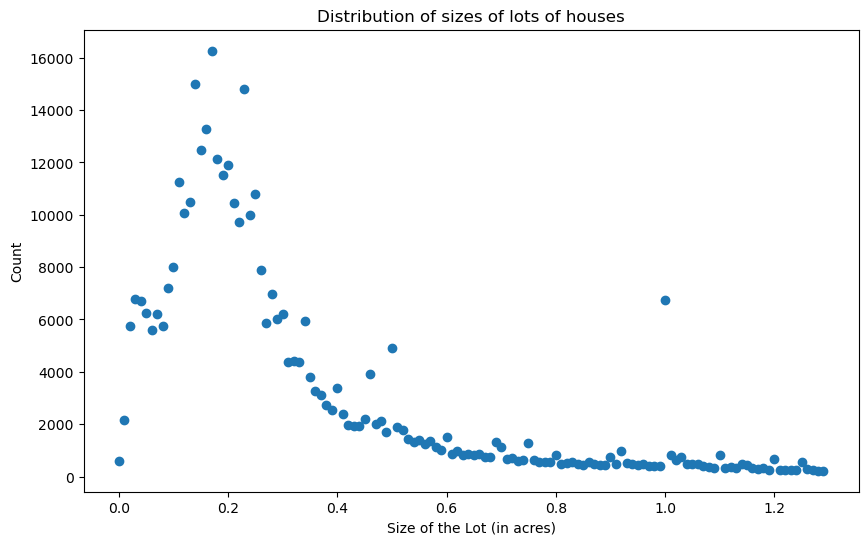

In [29]:
lot_counts = data2['lot_size'].value_counts()
plt.figure(figsize=(10, 6))
plt.scatter(lot_counts.index, lot_counts.values)
plt.xlabel("Size of the Lot (in acres)")
plt.ylabel("Count")
plt.title('Distribution of sizes of lots of houses')
plt.show();

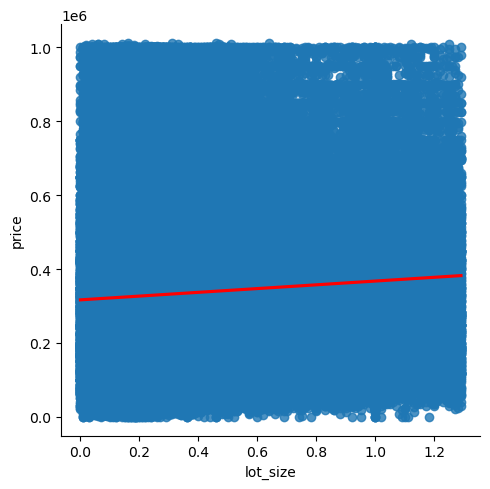

In [30]:
sns.lmplot(x='lot_size',y='price',data=data2, line_kws={'color': 'red'})
plt.show();

In [31]:
#Renaming house_size column to sqrfootage
data2.rename(columns={'house_size':'sqrfootage'}, inplace=True)

C:\Users\MTIDES\AppData\Local\Temp\ipykernel_2796\1794272047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.rename(columns={'house_size':'sqrfootage'}, inplace=True)


In [32]:
data2.sqrfootage.unique()

array([ 920., 1527.,  748., ..., 4167., 4207.,  587.])

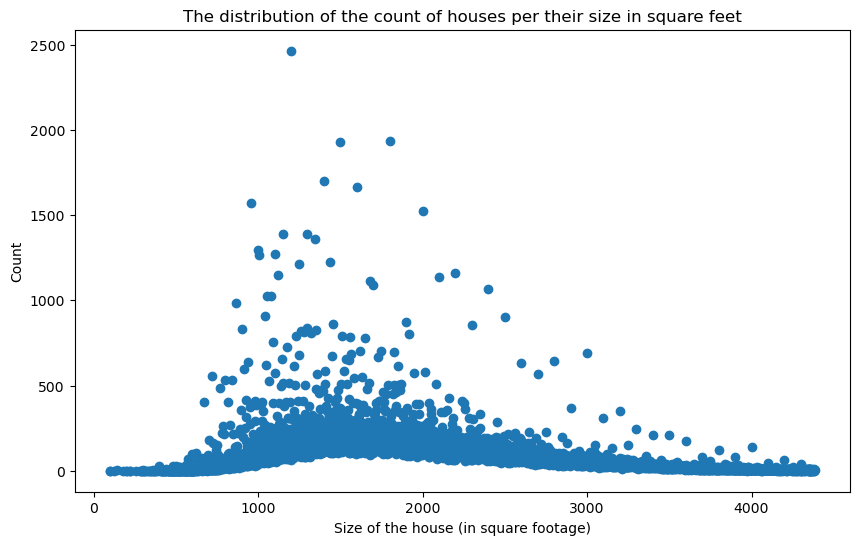

In [33]:
sqrfootage_counts = data2['sqrfootage'].value_counts()
plt.figure(figsize=(10, 6))
plt.scatter(sqrfootage_counts.index, sqrfootage_counts.values)
plt.xlabel("Size of the house (in square footage)")
plt.ylabel("Count")
plt.title('The distribution of the count of houses per their size in square feet')
plt.show();

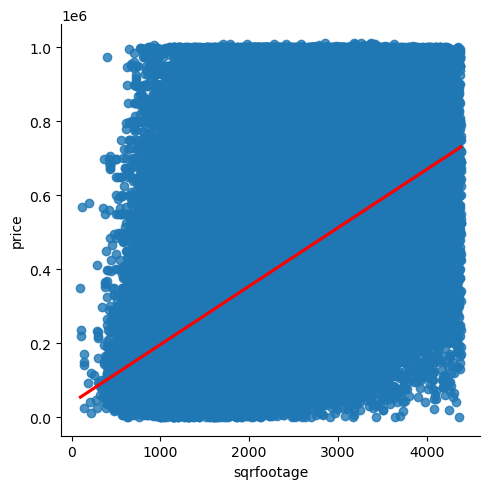

In [34]:
sns.lmplot(x='sqrfootage',y='price',data=data2, line_kws={'color': 'red'})

plt.show();

In [35]:
# Calculate Pearson correlation coefficient
correlation_matrix = data2_numeric.corr(method='pearson')

print("Pearson correlation coefficient matrix:")
print(correlation_matrix)

Pearson correlation coefficient matrix:
               price       bed      bath  acre_lot  house_size
price       1.000000  0.342416  0.575613  0.066818    0.572778
bed         0.342416  1.000000  0.502974  0.104645    0.607801
bath        0.575613  0.502974  1.000000  0.073412    0.700538
acre_lot    0.066818  0.104645  0.073412  1.000000    0.186950
house_size  0.572778  0.607801  0.700538  0.186950    1.000000


In [36]:
# Checking labels in the 'state' column
data2.state.unique()

array(['Puerto Rico', 'Virgin Islands', 'Massachusetts', 'Connecticut',
       'New Jersey', 'New Hampshire', 'Vermont', 'New York',
       'Rhode Island', 'Wyoming', 'Maine', 'West Virginia',
       'Pennsylvania', 'Delaware', 'Ohio', 'Maryland', 'Virginia',
       'Colorado', 'District of Columbia', 'North Carolina',
       'South Carolina', 'Kentucky', 'Tennessee', 'Georgia', 'Alabama',
       'Florida', 'Mississippi', 'Missouri', 'Arkansas', 'Louisiana',
       'Indiana', 'Illinois', 'Michigan', 'Wisconsin', 'Iowa',
       'Minnesota', 'South Dakota', 'Nebraska', 'North Dakota', 'Montana',
       'Idaho', 'Kansas', 'Oklahoma', 'Texas', 'New Mexico'], dtype=object)

In [37]:
grouped_data2 = data2.groupby(['state', 'zip_code']).count()
grouped_data2

brokered_by  status  price  bed  bath  lot_size  street  \
state   zip_code                                                            
Alabama 35004              36      36     36   36    36        36      36   
        35005              20      20     20   20    20        20      20   
        35006               7       7      7    7     7         7       7   
        35007              59      59     59   59    59        59      59   
        3501               10      10     10   10    10        10      10   
...                       ...     ...    ...  ...   ...       ...     ...   
Wyoming 82082               2       2      2    2     2         2       2   
        8224               24      24     24   24    24        24      24   
        82244               1       1      1    1     1         1       1   
        82414               1       1      1    1     1         1       1   
        82839               2       2      2    2     2         2       2   

                  city  sqrfootage  prev_sold_date  
state   zip_code                                    
Alabama 35004       36          36              21  
        35005       20          20              14  
        35006        7           7               6  
        35007       59          59              40  
        3501        10          10               4  
...                ...         ...             ...  
Wyoming 82082        2           2               1  
        8224        24          24               5  
        82244        1           1               0  
        82414        1           1               0  
        82839        2           2               0  

[18895 rows x 10 columns]

There seems to be zipcodes that are inaccurate. Further investigation is needed and the values addressed. 
Some States' zip-codes have leading zeros. They include:
New York (NY), Massachusetts (MA), Rhode Island (RI), New Hampshire (NH), Maine (ME), Vermont (VT), and Connecticut (CT). Other US territories include Puerto Rico (PR), Virgin Islands (VI), American Samoa (AS), and Guam (GU).

In [38]:
# Saving the DataFrame to a CSV file
data2.to_csv('EDAhousing_cleaned_data.csv', index=False)